# Improvement of "Malignant and Benign Breast Cancer Classification using Machine Learning Algorithms" study
Author: Ivan Klabučar - 0036513702, Jos netko, i jos netko

### Plan to improve the original study

In the study, they removed the ’fractal_dimension_mean’, ’texture_se’, and ’symmetry_se’ features on account of them not being highly correlated to the target variable. Just because a variable is not directly correlated with the target variable does not mean it is not useful for drawing a decision boundary in higer dimensional space. In fact in the first phase of the project we showed how the fractal_dimension_mean feature for example, although not very corraleted with the target variable, still has predictive power when plotted against the fractal_dimension_worst variable. Additionally, the study did not perform any feature scaling even though different features were on very different scales. In the first phase of the project we also showed how many of the independant variables were highly correlated with one another to the point of being transformations of one another. One such example are the radius_mean and perimeter_mean features which are perfectly colinear. This colinearity can cause problems for many ML algorithms, especially logistic regression. 

To address the above stated issues, we decided to improve upon the original study by:
- performing feature scaling, to bring all of the features to the same scale
- not removing ’fractal_dimension_mean’, ’texture_se’, and ’symmetry_se’ from the dataset so as not to lose their predictive power in higher dimensional space
- perforimg dimensionality reduction to get rid of the colinearity of features

### Algorithms tested in study

- Logistic Regression
- Support Vector Machine (SVM)
- Random Forest
- Naive Bayes
- Decision Tree
- K-Nearest Neighbors (KNN)

In the study, no mention of the exact configuration of hyperparameters of the models can be found. We will therefore use reasonable defaults from the sklearn library.

## Methodology

They split the original dataset into 25% testing and 75% training data sets randomly. They do not give percise specification of the split so we cannot recreate it. We will do our own random data split.

The models were first trained/fit on training data and then tested on test data.

For reproducibility reasons we will use random_state=42 where applicable.

## Evaluation metrics

For evaluation of models simple Accuracy was used. 

## Improvement

### Imports

In [14]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import requests
import io

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

#Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Omogucujemo prikaz vise podataka
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Utility functions:

In [2]:
# Utility function for plotting the confusion matrix
def plot_CFM(cfm, title):
    sns.heatmap(cfm, 
                annot=True, 
                fmt='d', 
                cmap="Blues",
                cbar=False,
                xticklabels= ['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title(title)
    plt.show()

# Utility function for plotting the ROC curve 'Receiver Operating Characteristic'
def plot_roc(fpr, tpr, roc_auc, title):
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Loading the data set and preprocessing

In [3]:
url = "https://archive.ics.uci.edu/static/public/17/data.csv"
x = requests.get(url=url, verify=False).content 
df = pd.read_csv(io.StringIO(x.decode('utf8')))

/Users/klabs/miniconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [4]:
df.head()

,ID,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


We need to remove:
- ID

from the dataset:

In [9]:
df.drop(columns=['ID'], inplace=True)

The target variable needs to be numeric, so we will apply the mapping B -> 0, M -> 1. In other words we consider 'malign' to be the positive class:

In [5]:
df['Diagnosis'] = df['Diagnosis'].map({'B': 0, 'M': 1})

In [14]:
df.Diagnosis.value_counts()

Diagnosis
0    357
1    212
Name: count, dtype: int64

## Proof of statements in the introduction

/Users/klabs/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


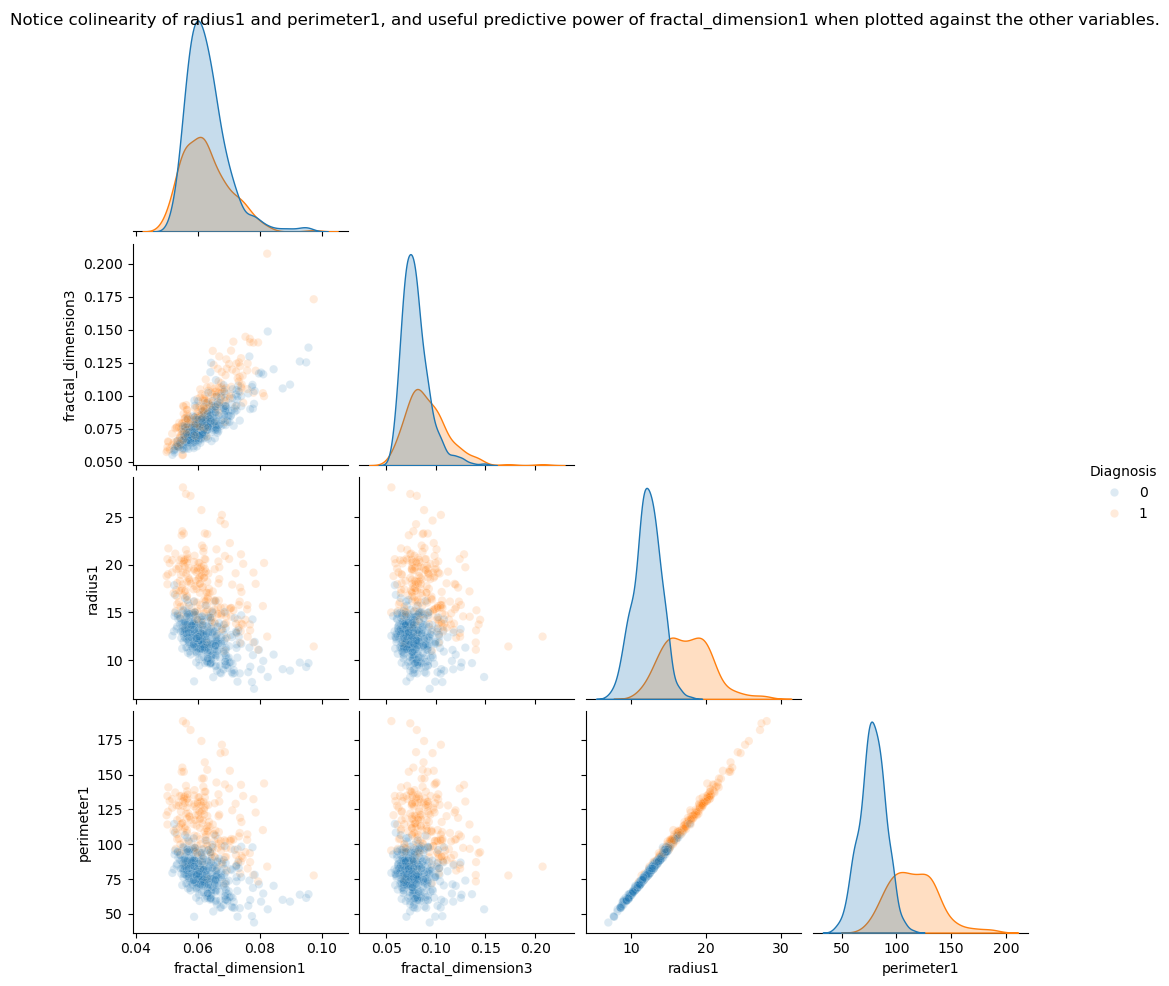

In [7]:
g=sns.pairplot(df[['fractal_dimension1', 'fractal_dimension3', 'radius1', 'perimeter1', 'Diagnosis']], 
             hue = "Diagnosis",
             corner = True, diag_kind='kde', plot_kws={'alpha': 0.15})
g.fig.suptitle('Notice colinearity of radius1 and perimeter1, and useful predictive power of fractal_dimension1 when plotted against the other variables.')
plt.show()

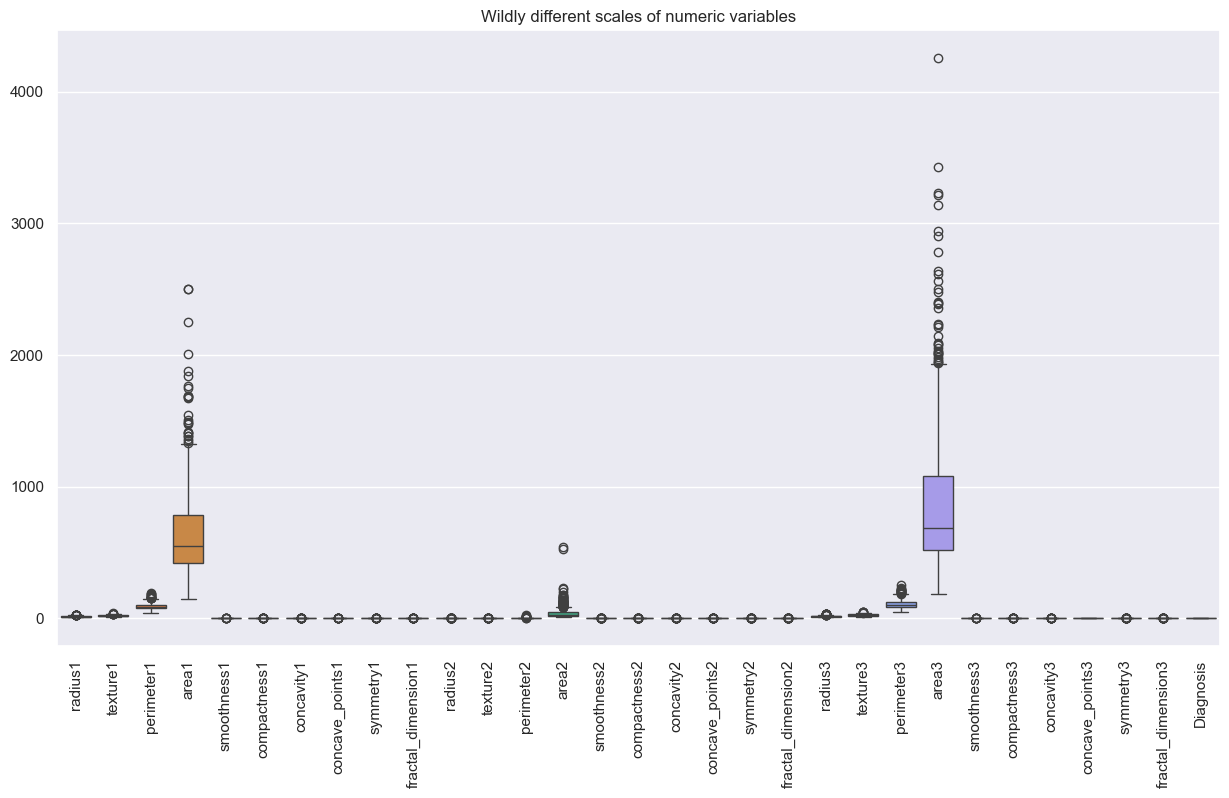

In [11]:
sns.set(rc={'figure.figsize':(15,8)})
ax=sns.boxplot(data=df).set(title='Wildly different scales of numeric variables')
plt.xticks(rotation=90)
plt.show()

## Performing the test set / training test split

We need to split the data into testing and training data with a 0.25 <-> 0.75 random split.

In [31]:
feature_names = list(df.columns)
feature_names.remove('Diagnosis')

y = df.Diagnosis.values
X = df[feature_names].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (426, 30)
X_test.shape: (143, 30)
y_train.shape: (426,)
y_test.shape: (143,)


## Performing scaling and PCA

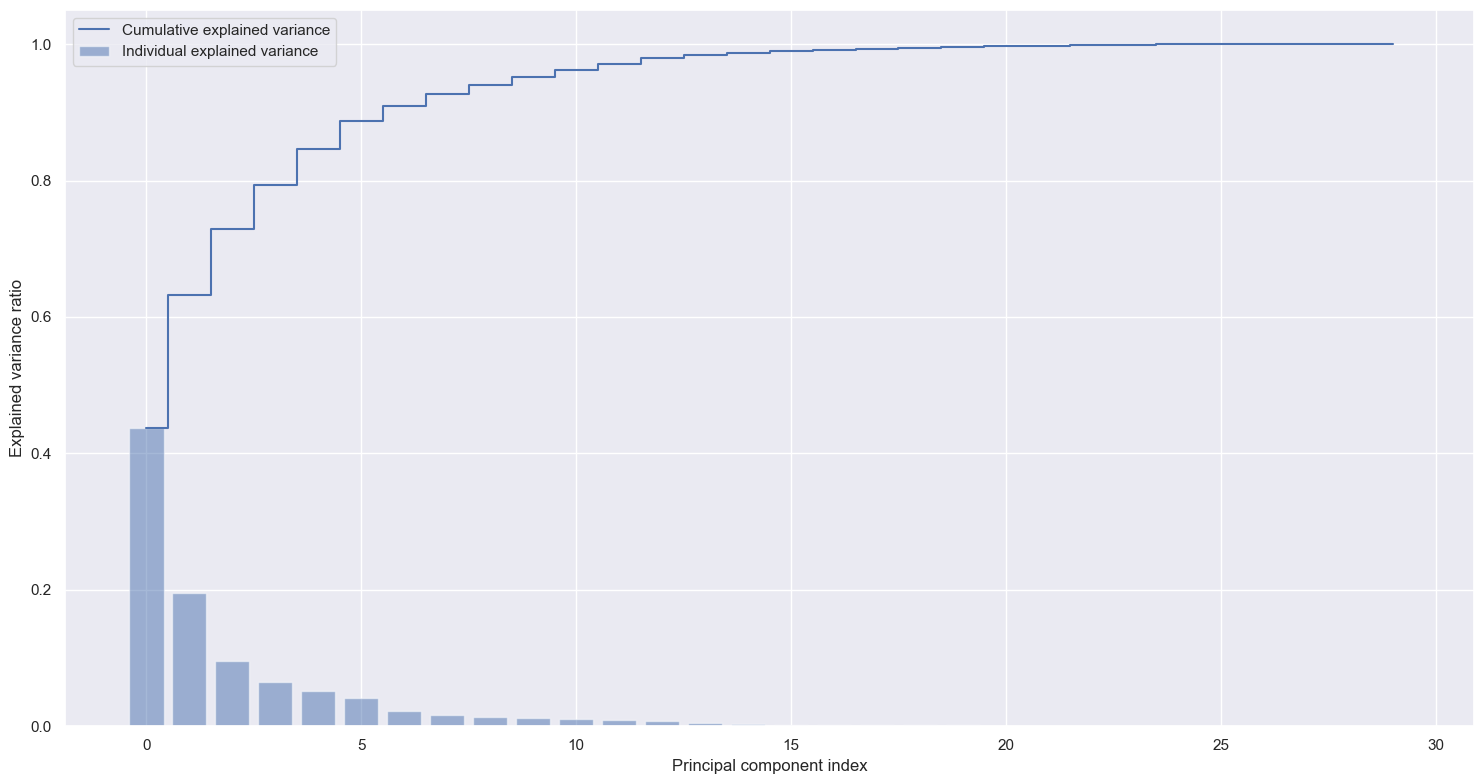

In [33]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

pca = PCA()
#
# Determine transformed features
#
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.close()
plt.cla()
plt.clf()
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Iz gornjeg grafa vidimo da polazni skup značajki možemo algoritmom PCA svesti na samo 5 značajki i očuvati nešto manje od 90% originalne varijance. 

In [34]:
cum_sum_eigenvalues[16]

0.9912229009303377

Ako se odlučimo za prvih 17 značajki, onda ćemo očuvati 99% polazne varijance dok smo dimenzionalnost prepolovili. To je moguće jer su nezavisne varijable bile visoko korelirane, što je PCA algoritam mogao iskoristiti da podatke preslika u prostor s bitno manje dimenzija bez da izgubi mnogo informacija.

Removal of insignificant variables:

In [40]:
X_train_pca = X_train_pca[:, :17]
X_test_pca = X_test_pca[:, :17]

In [41]:
X_train_pca.shape

(426, 17)

In [42]:
X_test_pca.shape

(143, 17)

## Model evaluation

We will evaluate every model defined in the MODELS_TO_EVAL dictionary. Evaluation will be comprised of calculating every metric defined in the MODEL_EVALUATION_RESULT dict and plotting the model's Confusion matrix as well as the ROC curve.

In [47]:
MODELS_TO_EVAL = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors (KNN, K=5)': KNeighborsClassifier(), #n_neighbors=5 is the default 
    'Decision Tree': tree.DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine (SVM)': SVC(probability=True, random_state=42)
}

MODEL_EVALUATION_RESULT = {
    'Model':                 None,
    'Training Accuracy (%)': None,
    'Testing Accuracy (%)':  None,
    'ROC_AUC':               None,
    'Precision (%)':         None,
    'Recall (%)':            None
}
results = []

Running the experiemnt:

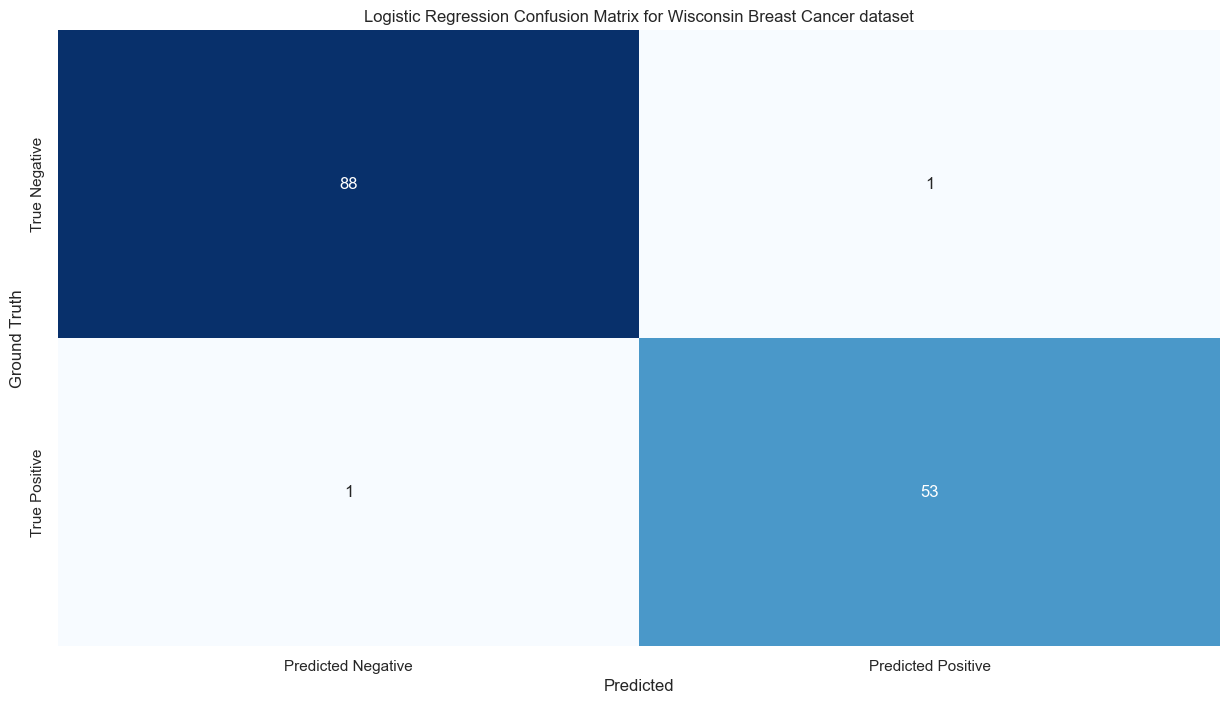

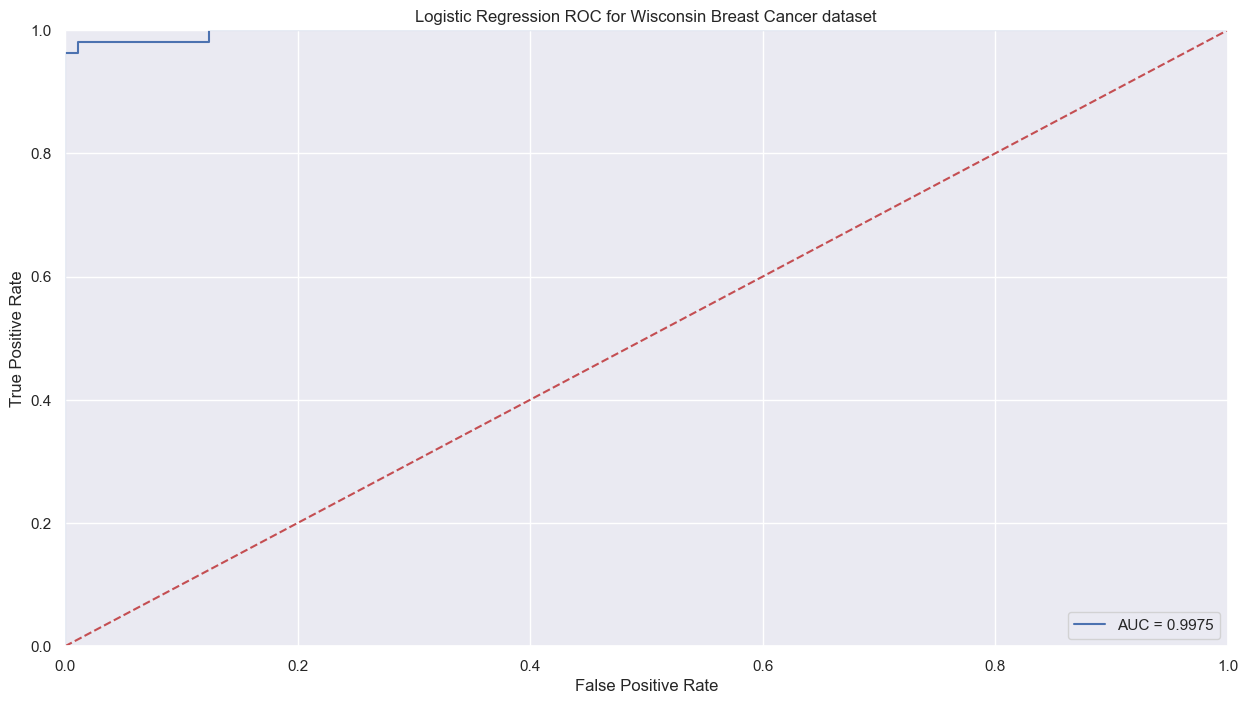

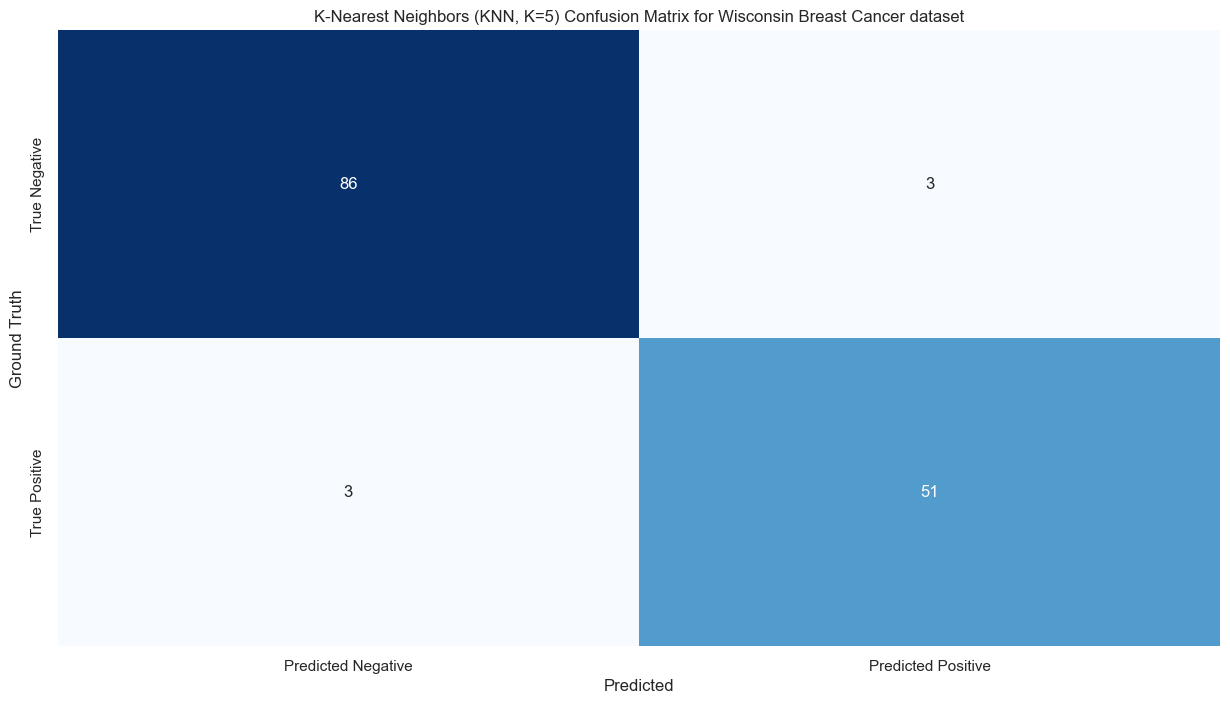

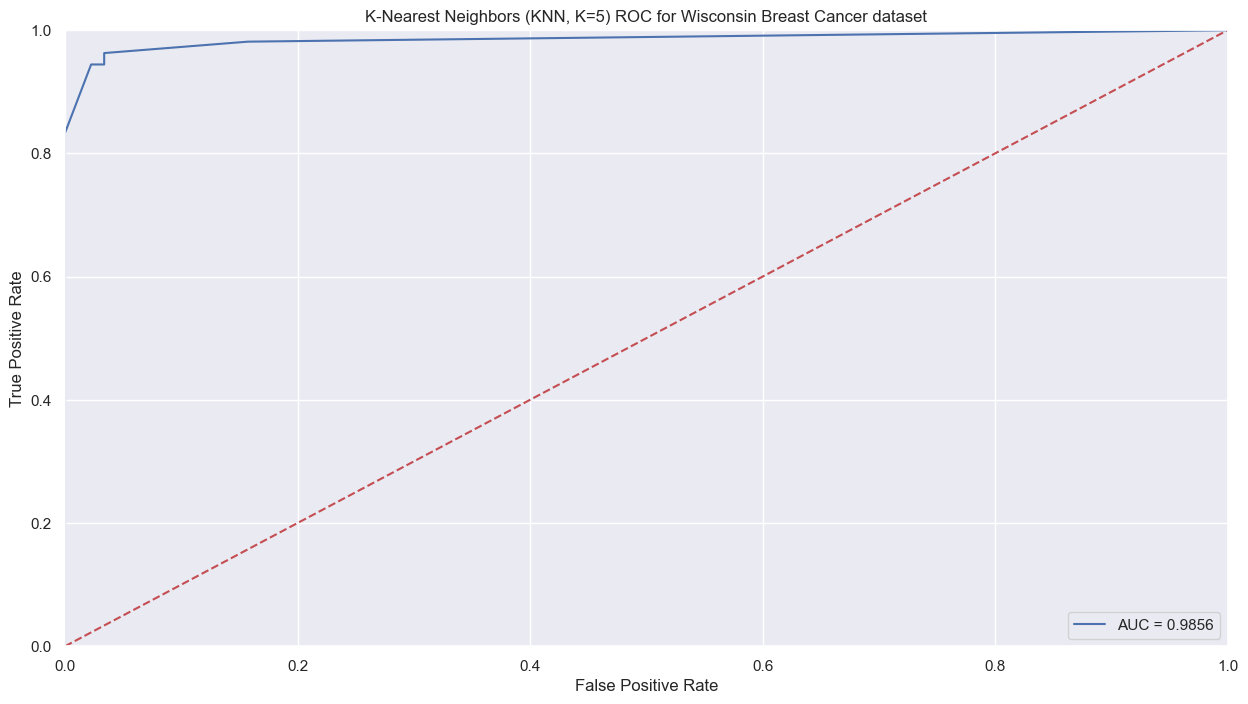

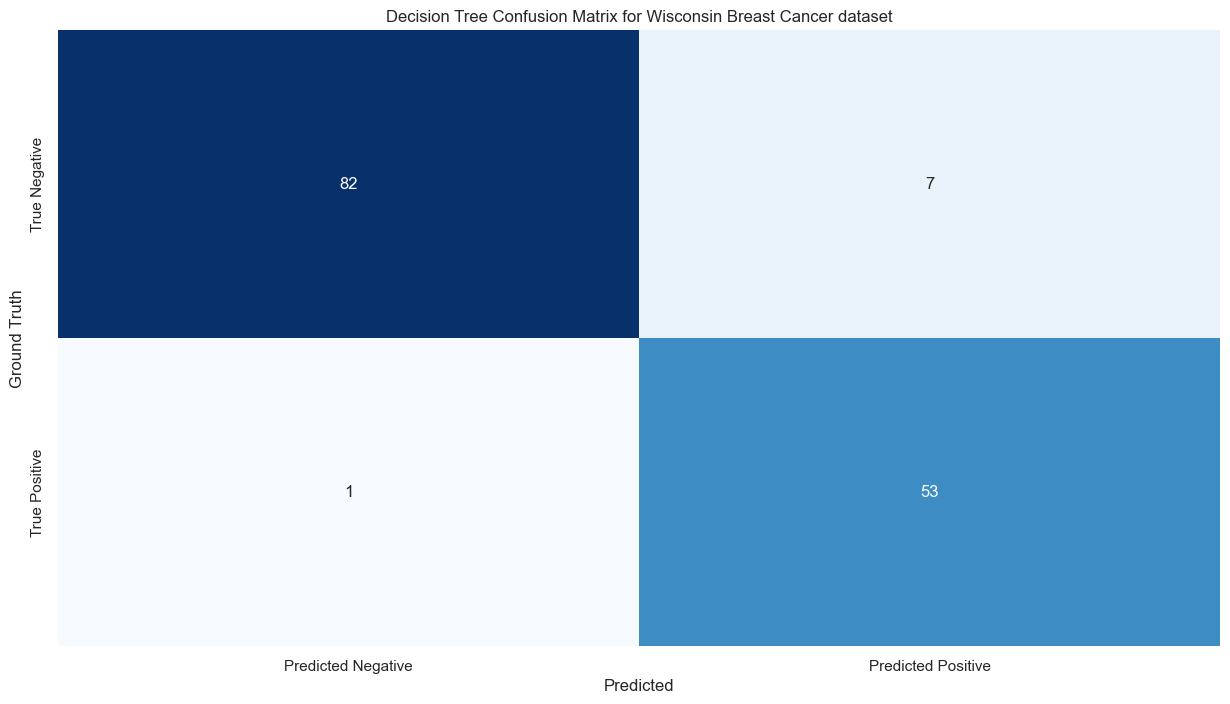

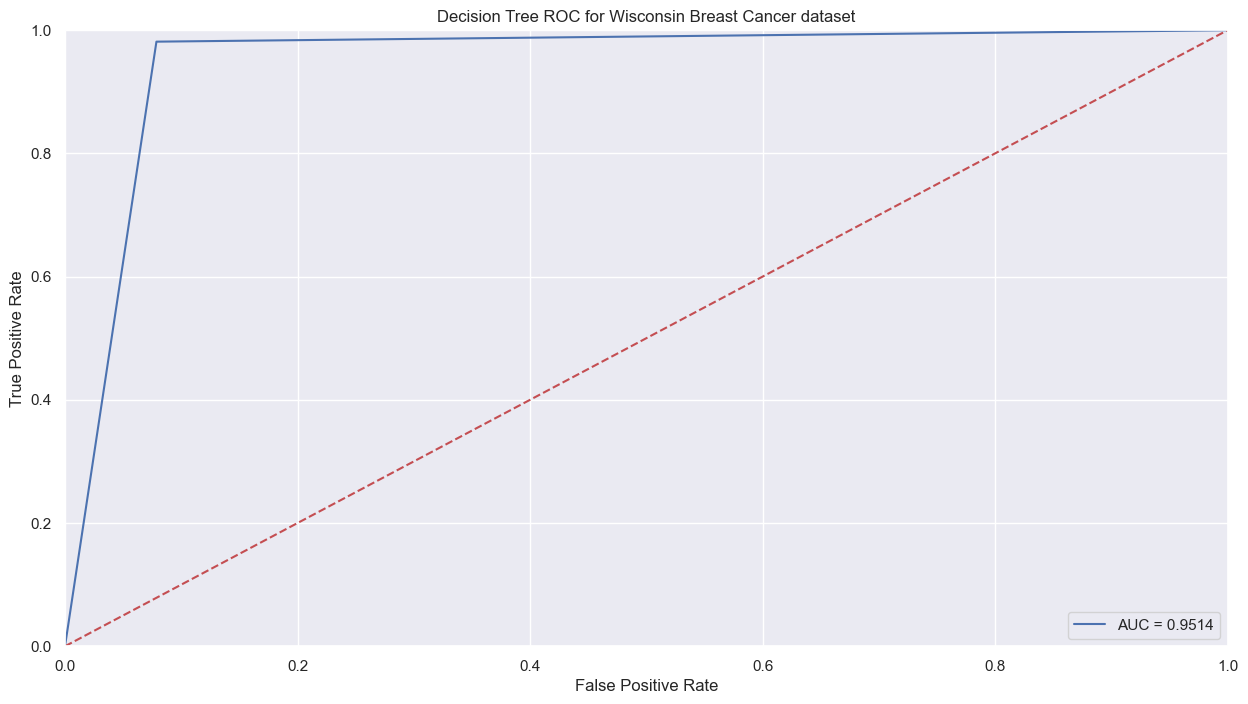

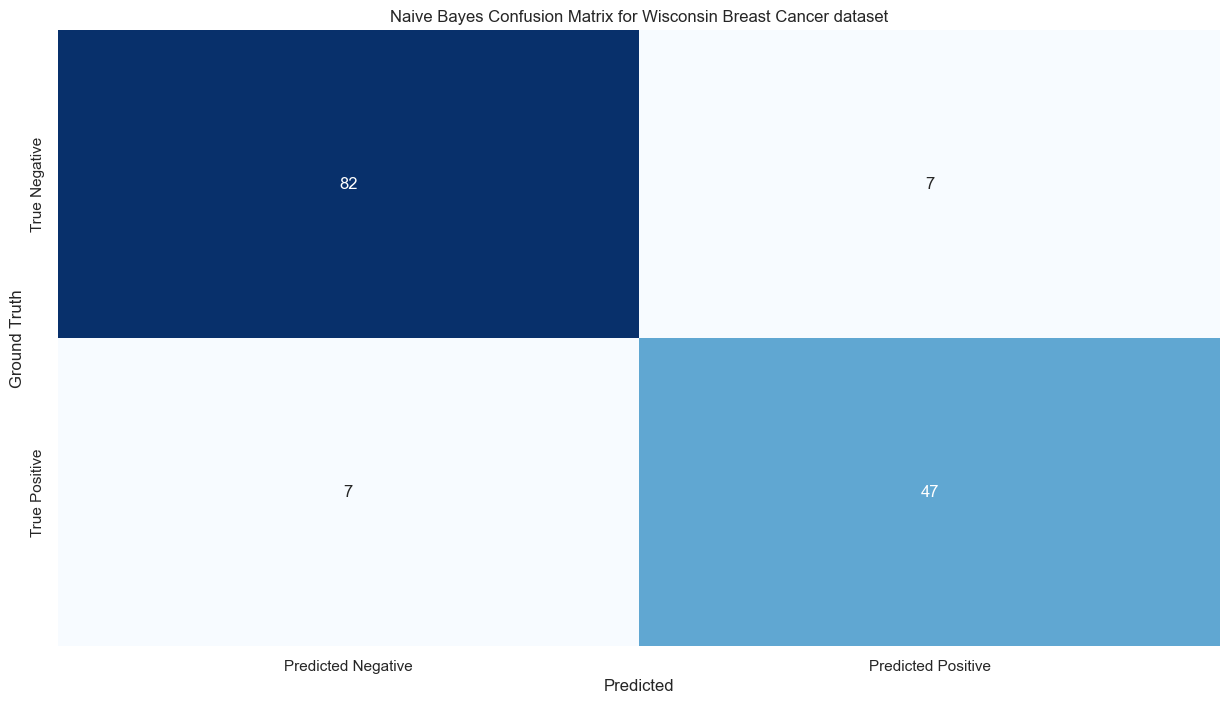

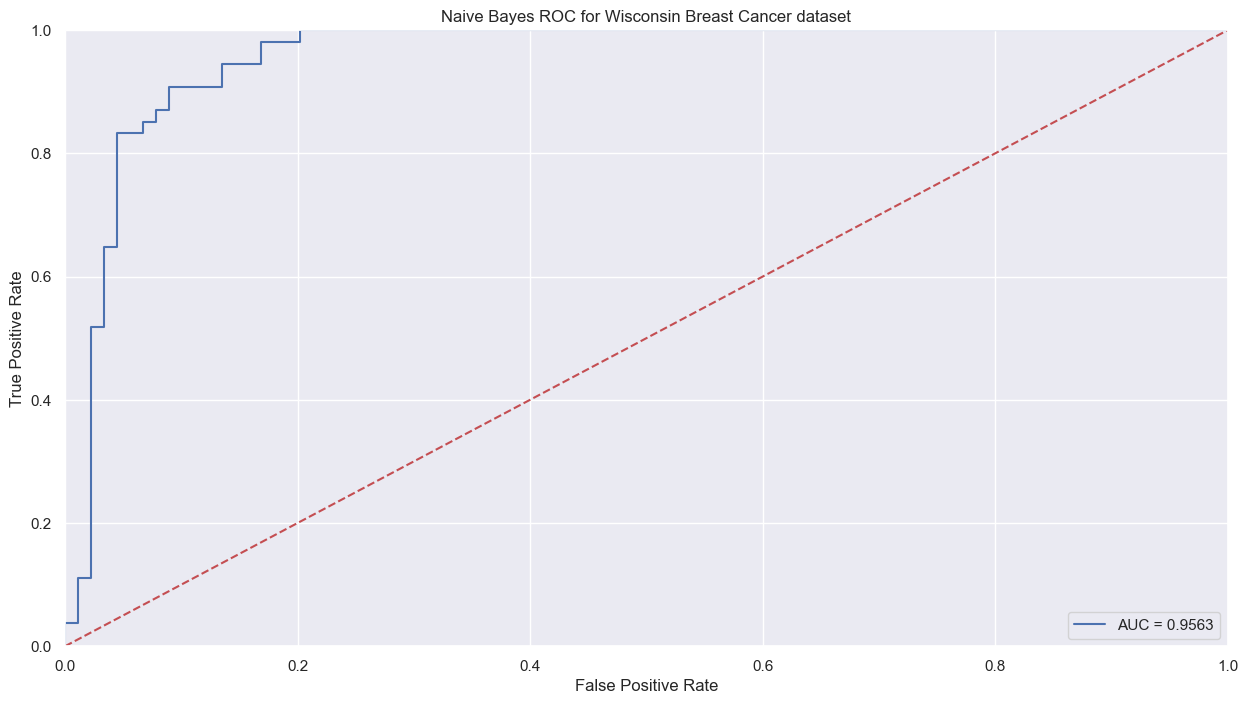

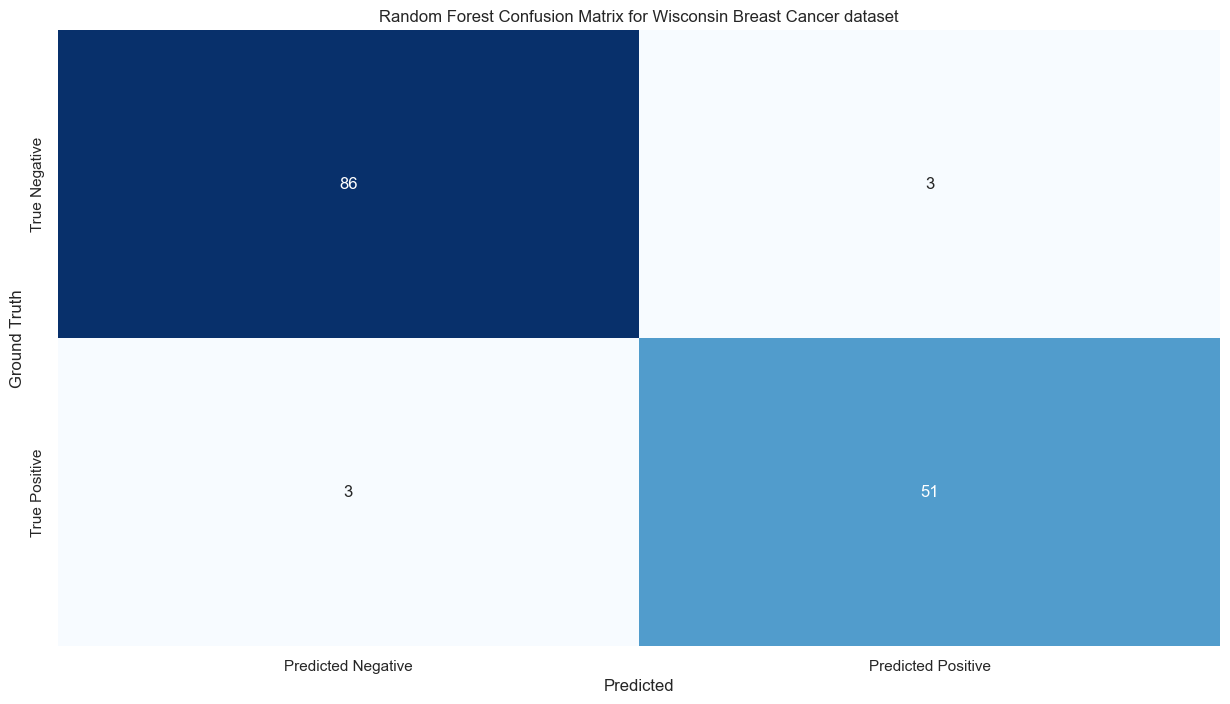

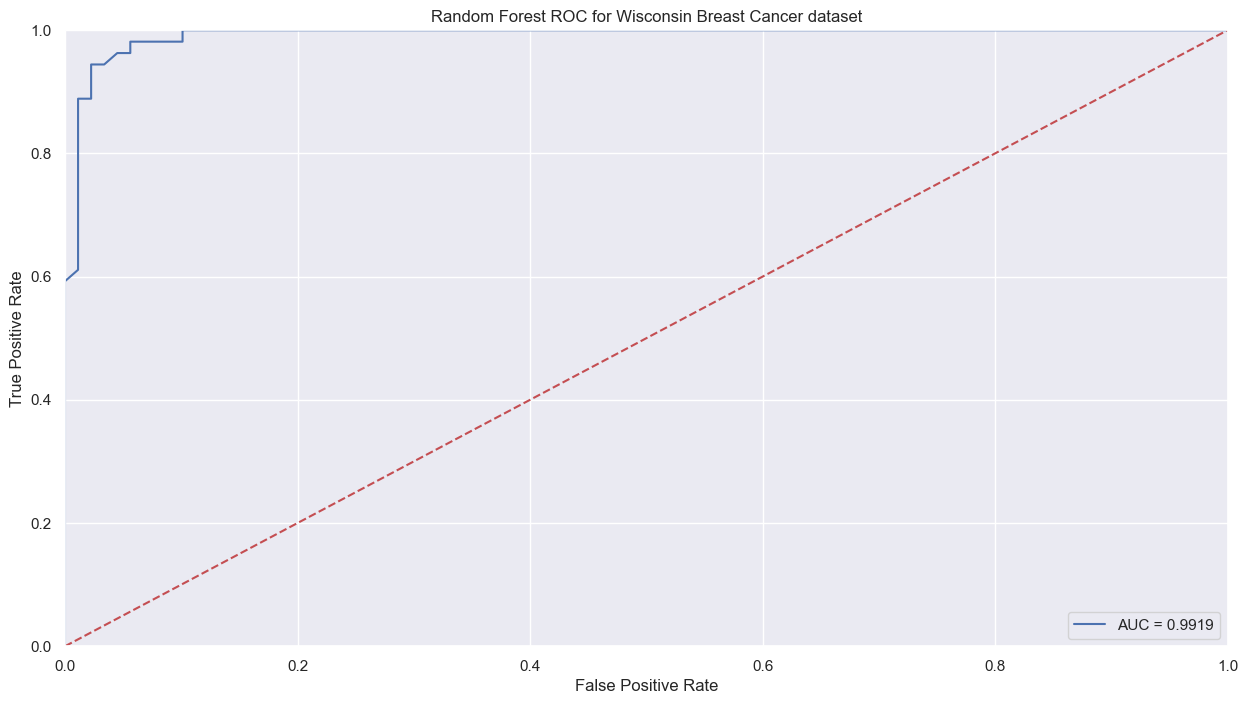

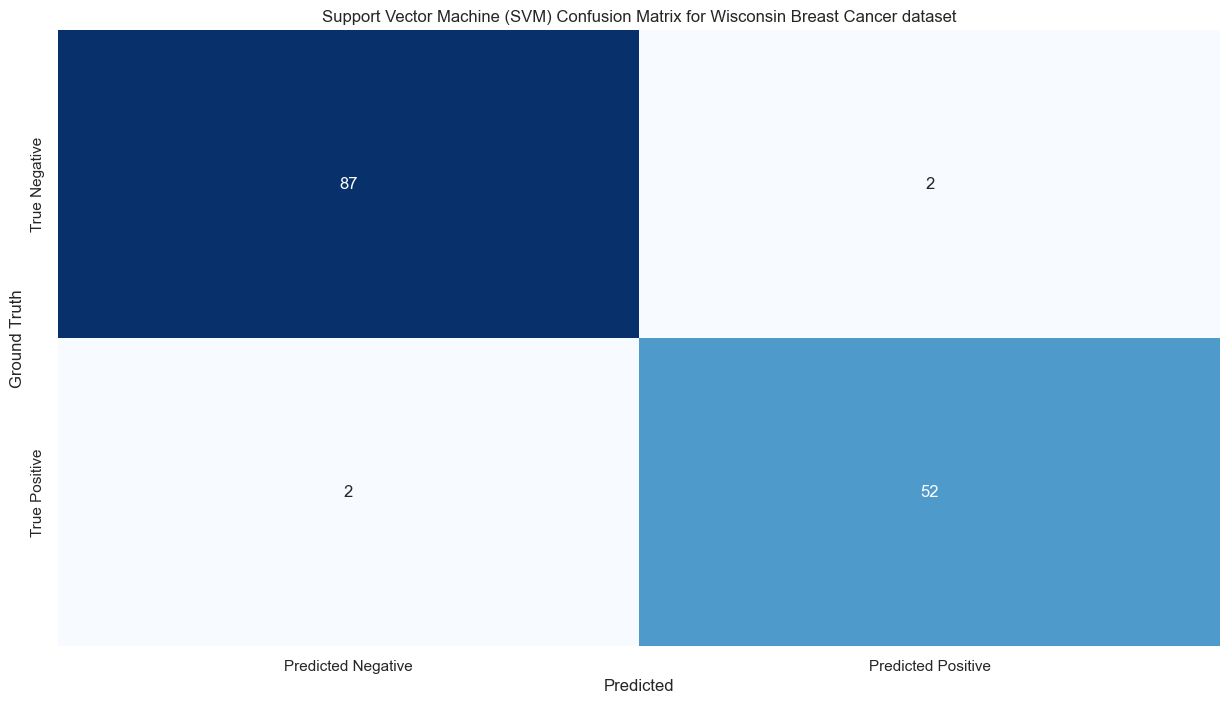

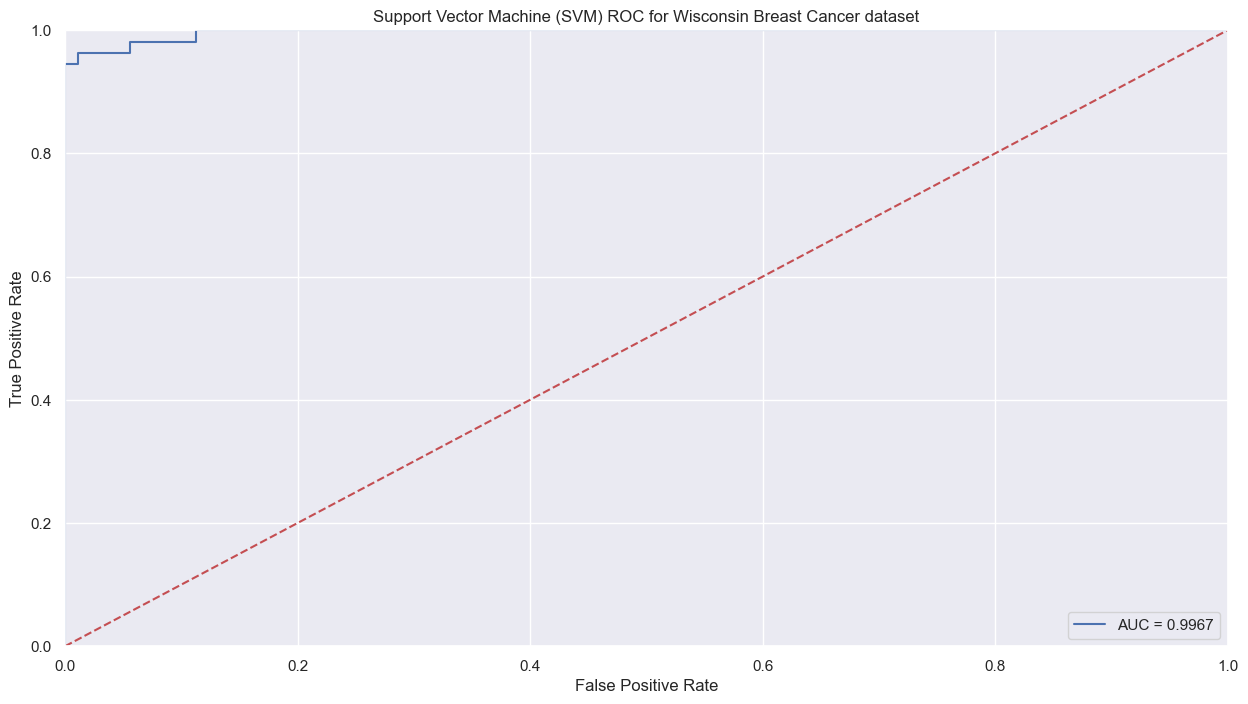

In [48]:
for model_name in MODELS_TO_EVAL:
    classifier = MODELS_TO_EVAL[model_name].fit(X_train_pca, y_train)
    
    train_predictions = classifier.predict(X_train_pca)
    test_predictions = classifier.predict(X_test_pca)
    malign_probabilities = classifier.predict_proba(X_test_pca)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, malign_probabilities)
    roc_auc = auc(fpr, tpr)

    curr_result = MODEL_EVALUATION_RESULT.copy()
    curr_result['Model'] = model_name
    curr_result['Training Accuracy (%)'] = round(accuracy_score(y_train, train_predictions) * 100, 1)
    curr_result['Testing Accuracy (%)'] = round(accuracy_score(y_test, test_predictions) * 100, 1)
    curr_result['ROC_AUC'] = round(roc_auc_score(y_test, malign_probabilities), 5)
    curr_result['Precision (%)'] = round(precision_score(y_test, test_predictions) * 100, 1)
    curr_result['Recall (%)'] = round(recall_score(y_test, test_predictions) * 100, 1)
    results.append(curr_result)

    # Plotting CFM and ROC
    CFM = confusion_matrix(y_test, test_predictions)
    plot_CFM(CFM, f'{model_name} Confusion Matrix for Wisconsin Breast Cancer dataset')
    plot_roc(fpr, tpr, roc_auc, f'{model_name} ROC for Wisconsin Breast Cancer dataset')

results = pd.DataFrame(results)

Results:

In [49]:
results

,Model,Training Accuracy (%),Testing Accuracy (%),ROC_AUC,Precision (%),Recall (%)
0,Logistic Regression,98.6,98.6,0.99750,98.1,98.1
1,"K-Nearest Neighbors (KNN, K=5)",97.9,95.8,0.98564,94.4,94.4
2,Decision Tree,100.0,94.4,0.95141,88.3,98.1
3,Naive Bayes,89.2,90.2,0.95630,87.0,87.0
4,Random Forest,100.0,95.8,0.99189,94.4,94.4
5,Support Vector Machine (SVM),98.8,97.2,0.99667,96.3,96.3


# Conclusion

The proposed improvements did achieve a higher accuracy on the test set than in the original study. The best performing models in our experiments were Logistic Regression with 98.6% test accuracy, and Support Vector Machine (SVM) with 97.2% test accuracy, compared to the maximum test accuracy of 96.5% in the original study.

On the other hand, K-Nearest Neighbors (KNN, K=5), Decision Tree, Naive Bayes, and Random Forest achieved a slightly lower test accuracy than in the original study.

However, looking at the test matrices, we can see that each model miscalssified only a very small number of samples. Which model is better is difficult to say when they differ in only a handful of miscalssified samples. Therefore, the improvements achieved for the two models do not appear very significant compared to the original study.